## Capstone Project - Winonsin Breast Cancer Diagnosis Deep Learning Revisited






#### Import necessary libraries

In [384]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from sklearn.model_selection import ShuffleSplit

from sklearn.preprocessing import MinMaxScaler

# Pretty display for notebooks
%matplotlib inline

#### Load in WBCD dataset

In [385]:
# Load the Boston housing dataset
headers = ["ID","CT","UCSize","UCShape","MA","SECSize","BN","BC","NN","Mitoses","Diagnosis"]
data = pd.read_csv('breast-cancer-wisconsin.csv', names = headers)
data = data.reset_index(drop=True)

#### Handle missing data
* Quite a few Bare Nuclei entries are missing and marked as "?".

In [386]:
data = data.replace('?', np.nan)
data = data.fillna(0)

#### Define a data generation function with random noise

In [387]:
def generateData(data):
    # make a copy of data
    data2 = data

    # separate labels from features
    diagnosis2 = data2['Diagnosis'] # labels
    features2 = data2.drop(['ID','Diagnosis'], axis = 1)
    features2_headers = ["CT","UCSize","UCShape","MA","SECSize","BN","BC","NN","Mitoses"]

    mean, sigma = 0, 0.1 
    # creating a noise with the same dimension as the dataset 
    noise = np.random.normal(mean, sigma, features2.shape) 

    features2 = features2.apply(pd.to_numeric, errors='ignore')

    features2_with_noise = features2.add(pd.DataFrame(noise, columns = features2_headers), fill_value=0)

    data2 = pd.concat([features2_with_noise, pd.DataFrame(diagnosis2)], axis = 1)
    
    return data2

#### Add the new generated dataset into the existing dataset

In [388]:
new_data = generateData(data)
data = data.append(new_data, ignore_index=True)

new_data = generateData(data)
data = data.append(new_data, ignore_index=True)

print("data size = ", data.size)

('data size = ', 30756)


#### Scale dataset to the range of [0, 1]

In [389]:
# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
numerical = ["Diagnosis","CT","UCSize","UCShape","MA","SECSize","BN","BC","NN","Mitoses"]
data[numerical] = scaler.fit_transform(data[numerical])

#### Separate Labels/Classes from Features

In [390]:
diagnosis = data['Diagnosis']
features = data.drop(['ID','Diagnosis'], axis = 1)

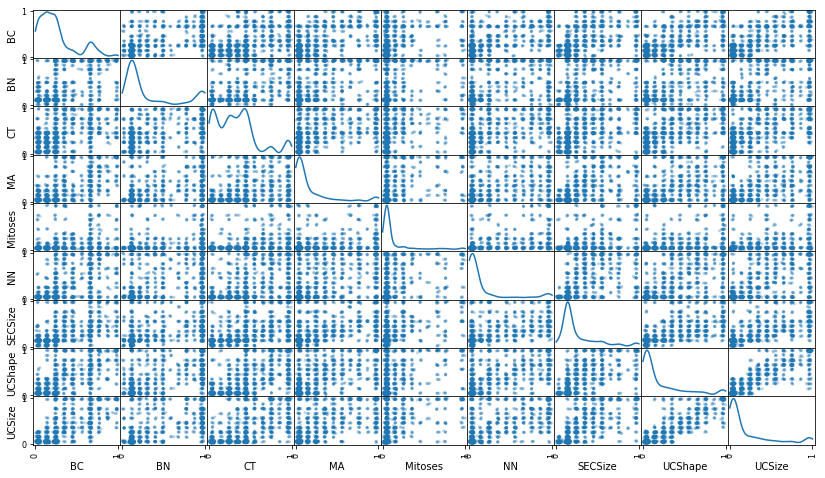

In [391]:
# Produce a scatter matrix for each pair of features in the data
pd.plotting.scatter_matrix(features, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

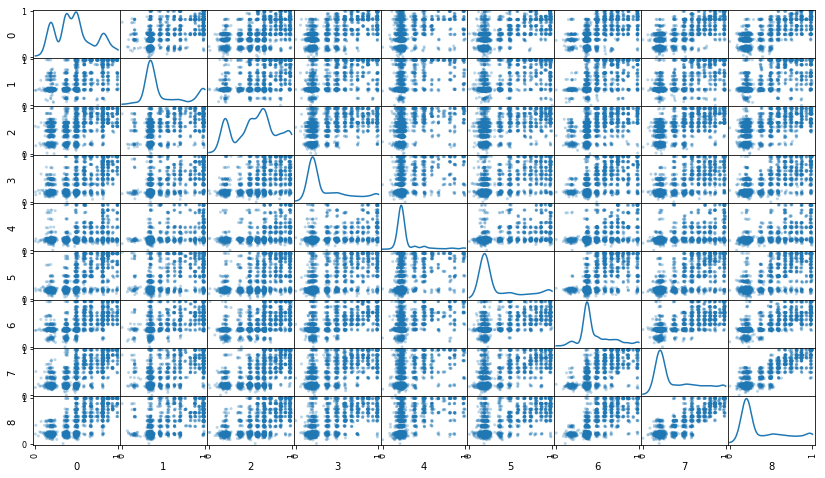

In [392]:
# Scale the data using the natural logarithm
sqrt_features = features.copy()

for feature_name in sqrt_features.columns:
    sqrt_features[feature_name] = np.sqrt(sqrt_features[feature_name]) 
    
sqrt_features = sqrt_features.replace([np.inf, -np.inf], np.nan)
sqrt_features = sqrt_features.fillna(0)

sqrt_features = scaler.fit_transform(sqrt_features)

# Produce a scatter matrix for each pair of newly-transformed features
pd.plotting.scatter_matrix(pd.DataFrame(sqrt_features), alpha = 0.3, figsize = (14,8), diagonal = 'kde');

# convert numpy ndarray into Pandas DataFrame
features = pd.DataFrame(sqrt_features)

#### Split dataset into training and testing datasets

In [393]:
from sklearn.model_selection import train_test_split

# Shuffle and split the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(features, diagnosis, test_size=0.25, random_state=42)

#### Reindex 

In [394]:
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

#### Convert Pandas DataFrame to Numpy ndarray
* This conversion is necessary because Pandas DataFrame is not consist with Keras API.

In [395]:
X_train = X_train.values
y_train = y_train.values
X_test  = X_test.values
y_test  = y_test.values

#### Classify dataset using Random Forest Classifier

In [396]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

score = rfc.score(X_test, y_test)
print("score = ", score)

('score = ', 0.98855507868383408)


#### Deep learning

In [397]:
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Sequential
import keras
import keras.utils
from keras import utils as np_utils

#### Define NN Architecture

In [398]:
model = Sequential()

#Define your architecture.
model.add(Dense(9, activation='relu', input_dim=9))
model.add(Dropout(0.5))
model.add(Dense(5, activation='relu', input_shape=(9,)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='relu', input_shape=(5,)))
model.add(Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_84 (Dense)             (None, 9)                 90        
_________________________________________________________________
dropout_43 (Dropout)         (None, 9)                 0         
_________________________________________________________________
dense_85 (Dense)             (None, 5)                 50        
_________________________________________________________________
dropout_44 (Dropout)         (None, 5)                 0         
_________________________________________________________________
dense_86 (Dense)             (None, 1)                 6         
_________________________________________________________________
dense_87 (Dense)             (None, 1)                 2         
Total params: 148
Trainable params: 148
Non-trainable params: 0
_________________________________________________________________


#### Compile NN Model

In [399]:
model.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

#### Train NN Model

In [400]:
model.fit(X_train, y_train, epochs=500, batch_size=32) # (500, 32) = 0.979

Epoch 1/500
2097/2097 [==============================] - 0s - loss: 0.6901 - acc: 0.6633     
Epoch 2/500
2097/2097 [==============================] - 0s - loss: 0.6787 - acc: 0.6633     
Epoch 3/500
2097/2097 [==============================] - 0s - loss: 0.6708 - acc: 0.6633     
Epoch 4/500
2097/2097 [==============================] - 0s - loss: 0.6565 - acc: 0.6633     
Epoch 5/500
2097/2097 [==============================] - 0s - loss: 0.6323 - acc: 0.6633     
Epoch 6/500
2097/2097 [==============================] - 0s - loss: 0.5929 - acc: 0.6633     
Epoch 7/500
2097/2097 [==============================] - 0s - loss: 0.5598 - acc: 0.6633     
Epoch 8/500
2097/2097 [==============================] - 0s - loss: 0.5313 - acc: 0.6633     
Epoch 9/500
2097/2097 [==============================] - 0s - loss: 0.4983 - acc: 0.6633     
Epoch 10/500
2097/2097 [==============================] - 0s - loss: 0.4887 - acc: 0.6633     
Epoch 11/500
2097/2097 [==============================] - 0

2097/2097 [==============================] - 0s - loss: 0.2326 - acc: 0.9008     
Epoch 87/500
2097/2097 [==============================] - 0s - loss: 0.2378 - acc: 0.9013     
Epoch 88/500
2097/2097 [==============================] - 0s - loss: 0.2215 - acc: 0.9099     
Epoch 89/500
2097/2097 [==============================] - 0s - loss: 0.2349 - acc: 0.8965     
Epoch 90/500
2097/2097 [==============================] - 0s - loss: 0.2112 - acc: 0.9123     
Epoch 91/500
2097/2097 [==============================] - 0s - loss: 0.2070 - acc: 0.9142     
Epoch 92/500
2097/2097 [==============================] - 0s - loss: 0.2132 - acc: 0.9156     
Epoch 93/500
2097/2097 [==============================] - 0s - loss: 0.2080 - acc: 0.9204     
Epoch 94/500
2097/2097 [==============================] - 0s - loss: 0.2176 - acc: 0.9137     
Epoch 95/500
2097/2097 [==============================] - 0s - loss: 0.2225 - acc: 0.9051     
Epoch 96/500
2097/2097 [==============================] - 0s - 

2097/2097 [==============================] - 0s - loss: 0.2047 - acc: 0.9065     
Epoch 172/500
2097/2097 [==============================] - 0s - loss: 0.2106 - acc: 0.9070     
Epoch 173/500
2097/2097 [==============================] - 0s - loss: 0.2060 - acc: 0.9075     
Epoch 174/500
2097/2097 [==============================] - 0s - loss: 0.2056 - acc: 0.9084     
Epoch 175/500
2097/2097 [==============================] - 0s - loss: 0.2080 - acc: 0.9051     
Epoch 176/500
2097/2097 [==============================] - 0s - loss: 0.2011 - acc: 0.9132     
Epoch 177/500
2097/2097 [==============================] - 0s - loss: 0.2031 - acc: 0.9070     
Epoch 178/500
2097/2097 [==============================] - 0s - loss: 0.2046 - acc: 0.9113     
Epoch 179/500
2097/2097 [==============================] - 0s - loss: 0.1968 - acc: 0.9132     
Epoch 180/500
2097/2097 [==============================] - 0s - loss: 0.2162 - acc: 0.9041     
Epoch 181/500
2097/2097 [=============================

2097/2097 [==============================] - 0s - loss: 0.1937 - acc: 0.9113     
Epoch 257/500
2097/2097 [==============================] - 0s - loss: 0.2010 - acc: 0.9118     
Epoch 258/500
2097/2097 [==============================] - 0s - loss: 0.2004 - acc: 0.9151     
Epoch 259/500
2097/2097 [==============================] - 0s - loss: 0.2099 - acc: 0.9103     
Epoch 260/500
2097/2097 [==============================] - 0s - loss: 0.2025 - acc: 0.9165     
Epoch 261/500
2097/2097 [==============================] - 0s - loss: 0.1992 - acc: 0.9180     
Epoch 262/500
2097/2097 [==============================] - 0s - loss: 0.1972 - acc: 0.9170     
Epoch 263/500
2097/2097 [==============================] - 0s - loss: 0.2162 - acc: 0.8994     
Epoch 264/500
2097/2097 [==============================] - 0s - loss: 0.2032 - acc: 0.9046     
Epoch 265/500
2097/2097 [==============================] - 0s - loss: 0.1905 - acc: 0.9146     
Epoch 266/500
2097/2097 [=============================

2097/2097 [==============================] - 0s - loss: 0.1940 - acc: 0.9161     
Epoch 340/500
2097/2097 [==============================] - 0s - loss: 0.2004 - acc: 0.9132     
Epoch 341/500
2097/2097 [==============================] - 0s - loss: 0.1995 - acc: 0.9127     
Epoch 342/500
2097/2097 [==============================] - 0s - loss: 0.1954 - acc: 0.9127     
Epoch 343/500
2097/2097 [==============================] - 0s - loss: 0.1925 - acc: 0.9151     
Epoch 344/500
2097/2097 [==============================] - 0s - loss: 0.2083 - acc: 0.9046     
Epoch 345/500
2097/2097 [==============================] - 0s - loss: 0.2096 - acc: 0.9065     
Epoch 346/500
2097/2097 [==============================] - 0s - loss: 0.1994 - acc: 0.9123     
Epoch 347/500
2097/2097 [==============================] - 0s - loss: 0.1842 - acc: 0.9199     
Epoch 348/500
2097/2097 [==============================] - 0s - loss: 0.1879 - acc: 0.9208     
Epoch 349/500
2097/2097 [=============================

2097/2097 [==============================] - 0s - loss: 0.1889 - acc: 0.9156     
Epoch 424/500
2097/2097 [==============================] - 0s - loss: 0.1977 - acc: 0.9142     
Epoch 425/500
2097/2097 [==============================] - 0s - loss: 0.1848 - acc: 0.9218     
Epoch 426/500
2097/2097 [==============================] - 0s - loss: 0.1957 - acc: 0.9108     
Epoch 427/500
2097/2097 [==============================] - 0s - loss: 0.2112 - acc: 0.9013     
Epoch 428/500
2097/2097 [==============================] - 0s - loss: 0.1872 - acc: 0.9218     
Epoch 429/500
2097/2097 [==============================] - 0s - loss: 0.2057 - acc: 0.9056     
Epoch 430/500
2097/2097 [==============================] - 0s - loss: 0.1923 - acc: 0.9194     
Epoch 431/500
2097/2097 [==============================] - 0s - loss: 0.2088 - acc: 0.9022     
Epoch 432/500
2097/2097 [==============================] - 0s - loss: 0.2028 - acc: 0.9113     
Epoch 433/500
2097/2097 [=============================

#### Test NN Model

In [401]:
score = model.evaluate(X_test, y_test, batch_size=32)
print("score = ", score)

 32/699 [>.............................] - ETA: 4s('score = ', [0.074697327598908084, 0.98283261802575106])
